In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()


import warnings
warnings.filterwarnings("ignore")



In [ ]:
sbi_share_eps = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Banks/sbi/chart.csv')
sbi_share_eps["DateTime"] = pd.to_datetime(sbi_share_eps["DateTime"])

hdfcbank_share_eps = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Banks/hdfcbank/chart.csv')
hdfcbank_share_eps["DateTime"] = pd.to_datetime(hdfcbank_share_eps["DateTime"])

icicibank_share_eps = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Banks/icicibank/chart.csv')
icicibank_share_eps["DateTime"] = pd.to_datetime(icicibank_share_eps["DateTime"])

bankofbaroda_share_eps = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Banks/bankofbaroda/chart.csv')
bankofbaroda_share_eps["DateTime"] = pd.to_datetime(bankofbaroda_share_eps["DateTime"])



In [2]:
def lin_reg(df, start_time, end_time, show_plots=False):

  mask = ((df['DateTime'] > pd.to_datetime(start_time)) & (df['DateTime'] < pd.to_datetime(end_time)))
  df_range = df.loc[mask].dropna()
  X = (df_range.iloc[:,0] - df_range.iloc[0, 0]).dt.days.values.reshape(-1,1)
  y = df_range.iloc[:, 1].values.reshape(-1,1)
  reg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False).fit(X, y)

  x = df[((df['DateTime'] > pd.to_datetime(start_time)) & (df['DateTime'] < pd.to_datetime(end_time)))]
  xs = (x.iloc[:,0] - x.iloc[0,0]).dt.days.values.reshape(-1,1)
  ypred = reg.predict(xs)
 
  if (show_plots):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(10)

    plt.plot(x.iloc[:,0].values, ypred)
    plt.plot(df.iloc[:,0].values, df.iloc[:,1])
    plt.axvline(dt.datetime(2020, 3, 24), color="black")


    plt.title(df.columns[1] + " share price vs estimate")
    plt.xlabel("Date")
    plt.ylabel(df.columns[1])

    plt.xlim(dt.datetime(2014,1,1), dt.datetime(2022,12,30))
    lims = reg.predict([[0], [365]])
    cagr = (lims[1] - lims[0]) / lims[0]

    plt.legend(["actual price", "linear estimate", "lockdown announcement"], prop={'size': 12})

    plt.show()
  return reg


In [3]:
def drop_details(df):
  uncertainty_date = "2020-02-28"
  mask = (df['DateTime'] > pd.to_datetime(uncertainty_date))
  peak_row = df[df['DateTime'] == uncertainty_date+" 05:30"]
  post_uncertainty_df = df[mask]
  drop_row = post_uncertainty_df.loc[post_uncertainty_df.iloc[:,1].idxmin()]
  drop_percent = 100 * (peak_row.iloc[0,1] - drop_row.iloc[1]) / peak_row.iloc[0,1]
  return drop_percent, peak_row.iloc[0,0], peak_row.iloc[0,1], drop_row.iloc[0], drop_row.iloc[1]




In [ ]:

dh = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Hospitality/Indian Hotels/chart.csv')
dh["DateTime"] = pd.to_datetime(dh["DateTime"])

drop_details(dh)

(53.851851851851855,
 Timestamp('2020-02-28 05:30:00'),
 135.0,
 Timestamp('2020-05-18 05:30:00'),
 62.3)

In [4]:
def estimate_crossover(df, model_start_time, model_end_time, crossover_after_time, end_time):
  reg = lin_reg(df, model_start_time, model_end_time)
  
  x = df[((df['DateTime'] > pd.to_datetime(model_start_time)) & (df['DateTime'] < pd.to_datetime(end_time)))]
  xs = (x.iloc[:,0] - x.iloc[0,0]).dt.days.values.reshape(-1,1)
  ypred = reg.predict(xs)
  ypred_df = pd.DataFrame({"DateTime":x.iloc[:,0].values, "predicted": ypred.reshape(1,-1)[0]})
  
  x.set_index("DateTime")
  ypred_df.set_index("DateTime")

  join_df = x.merge(ypred_df, how="inner", left_on="DateTime", right_on="DateTime")
  
  drop_percent, peak_date, peak_value, drop_date, drop_value = drop_details(shares_df)

  print(drop_date)
  val = join_df[(join_df["DateTime"]>pd.to_datetime(drop_date)) & (join_df.iloc[:,1] > join_df["predicted"])]
  first_crossover_date = val.iloc[0,0]

  f = plt.figure()
  f.set_figwidth(20)
  f.set_figheight(10)

  plt.plot(x.iloc[:,0].values, ypred)
  plt.plot(df.iloc[:,0].values, df.iloc[:,1])
  plt.axvline(pd.to_datetime(model_end_time), color="black", linestyle='dashed')
  plt.axvline(first_crossover_date, color="green", linestyle='dashed')


  plt.title(df.columns[1] + " share price vs estimate")
  plt.xlabel("Date")
  plt.ylabel(df.columns[1])

  plt.xlim(dt.datetime(2014,1,1), dt.datetime(2022,12,30))

  lims = reg.predict([[365], [730]])
  cagr = ((lims[1][0] - lims[0][0]) / lims[0][0]) * 100

  plt.legend(["actual price", "linear estimate", "lockdown announcement", "first crossover"], prop={'size': 12})

  plt.show()

  recovery_rate = ((val.iloc[0,1] - drop_value)/drop_value) * 100
  recovery_time = (first_crossover_date - pd.to_datetime(model_end_time)).days


  return first_crossover_date, drop_percent, peak_value, drop_value, cagr, recovery_rate, recovery_time
 
  

In [5]:
stock_domain_name = "Hospitality/EIH/chart.csv"


common_path = '/content/drive/MyDrive/MCOM Research/Data/'
data_path = common_path + stock_domain_name
shares_df = pd.read_csv(data_path)
shares_df["DateTime"] = pd.to_datetime(shares_df["DateTime"])
out = estimate_crossover(shares_df, "2018-01-01", "2020-02-28", "2020-03-01", "2022-10-20")

print("Recvocery date = " + str(out[0]))
print("Drop percent = " +  str(out[1]))
print("Pre-Covid Peak = " + str(out[2]))
print("Post-Covid Low = " + str(out[3]))
print("Pre-Covid CAGR = " + str(out[4]))
print("Post-Covid Recovery Rate = " +str(out[5]))
print("Recovery Time = " + str(out[6]) + " days")


NameError: ignored

In [24]:
# Consolidated analysis


cdf = pd.read_csv('/content/drive/MyDrive/MCOM Research/Data/Consolidated.csv')
cdf = cdf[(cdf["Company name"] != 'United Spirits') & (cdf["Company name"] != 'United Brewerie') &  (cdf["Company name"] != 'Varun Beverages') &  (cdf["Company name"] != 'Godfrey Phillip')]
cdf

,Sector,Company name,Recovery Date tr,downfall,Pre-Covid Peak,Post-Covid Low,Pre-Covid CAGR,Post-Covid Recovery Rate rr,Recovery Time tr
0,Automobiles,Bajaj Auto,2020-07-28 5:30:00,33.025952,2890.000,1935.550,3.568320,61.160910,151
1,Automobiles,Eicher Motors,2020-11-11 5:30:00,23.624969,1660.235,1268.005,-1.364798,83.492967,257
2,Automobiles,Hero Motorcorp,2020-07-03 5:30:00,24.284148,2051.750,1553.500,-4.858203,76.263276,126
3,Automobiles,Tata Motors,2020-06-05 5:30:00,49.360217,128.950,65.300,-21.892410,69.601838,98
4,Banks,BOB,2021-02-18 5:30:00,52.162516,76.300,36.500,-10.534025,162.054795,356
5,Banks,HDFC,2021-01-12 5:30:00,34.810852,1177.650,767.700,27.510069,92.913899,319
6,Banks,ICICI,2020-12-14 5:30:00,42.885872,497.250,284.000,28.445823,85.140845,290
7,Banks,SBI,2021-02-04 5:30:00,50.214521,303.000,150.850,10.902630,135.399403,342
8,Hospitality,EIH,2021-10-18 5:30:00,58.285931,131.850,55.000,-5.971000,161.450000,598
9,Hospitality,Indian Hotels,2021-09-20 5:30:00,53.851852,135.000,62.300,4.914000,158.500000,570


In [25]:
cdfg = cdf.groupby("Sector").aggregate("mean")
cdfg

,downfall,Pre-Covid Peak,Post-Covid Low,Pre-Covid CAGR,Post-Covid Recovery Rate rr,Recovery Time tr
Sector,,,,,,
Automobiles,32.573821,1682.733750,1205.588750,-6.136773,72.629748,158.00
Banks,45.018441,513.550000,309.762500,14.081124,118.877235,326.75
FMCG,26.020016,1830.366667,1400.883333,31.515859,43.679339,66.00
Hospitality,56.068891,133.425000,58.650000,-0.528500,159.975000,584.00
IT,24.246189,871.912500,682.737500,14.944579,83.554457,269.50
NBFC,54.101281,2259.812500,996.337500,40.369272,148.472535,286.25


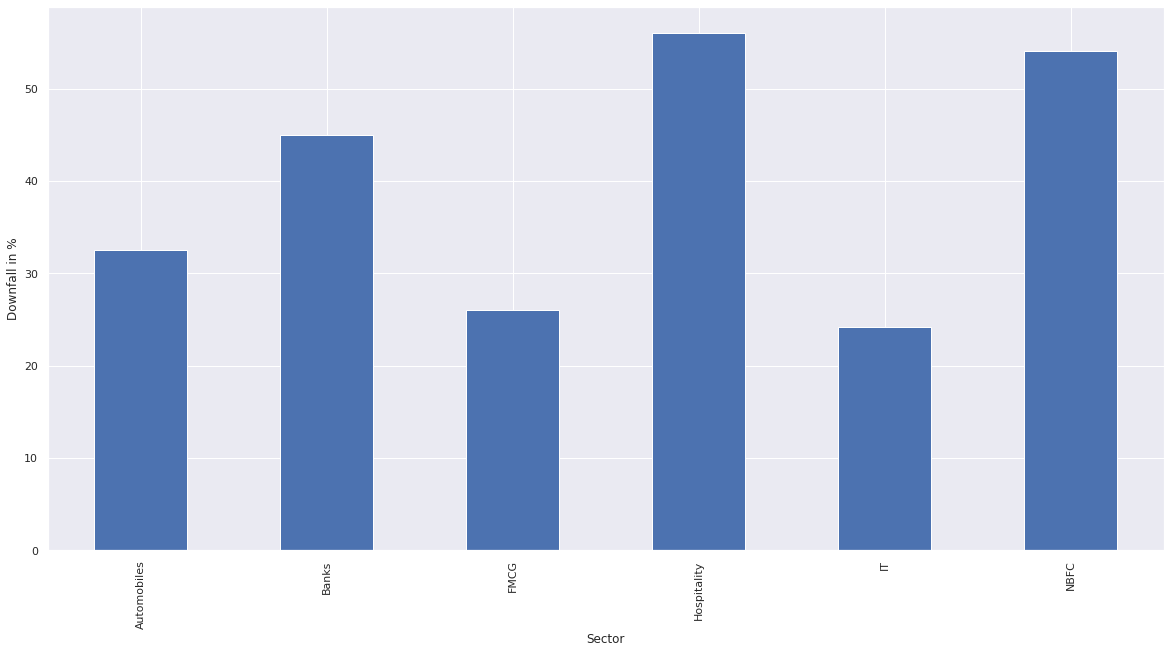

In [31]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.xlabel("Sector")
plt.ylabel("Downfall in %")

cdfg["downfall"].plot.bar()

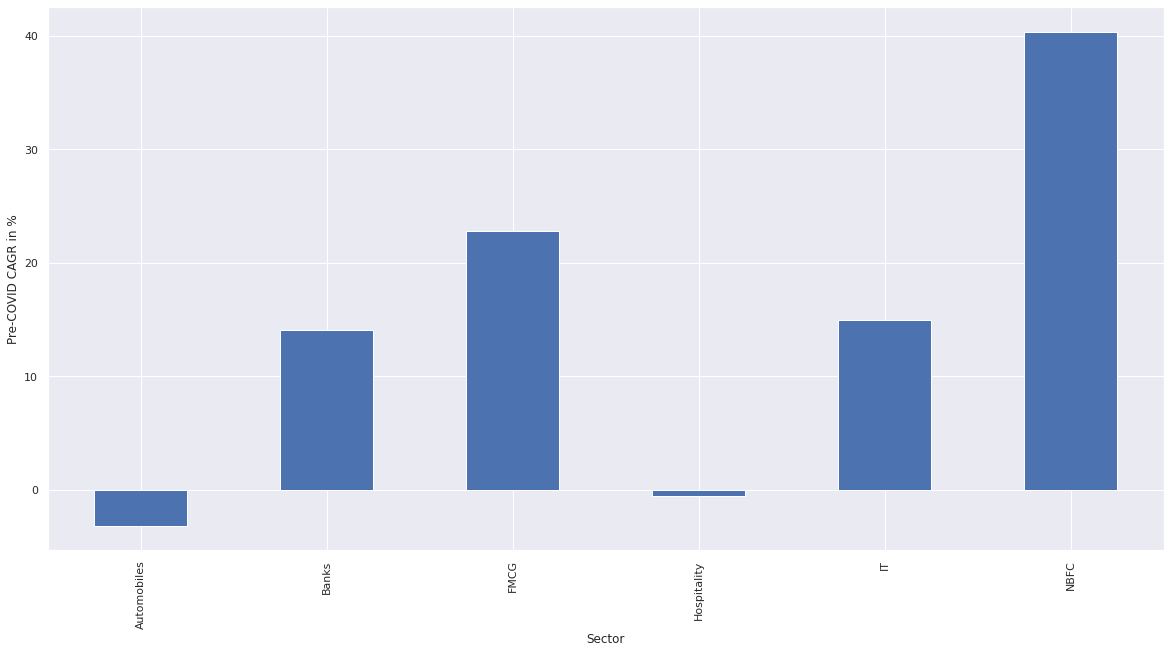

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.xlabel("Sector")
plt.ylabel("Pre-COVID CAGR in %")

cdfg["Pre-Covid CAGR"].plot.bar()

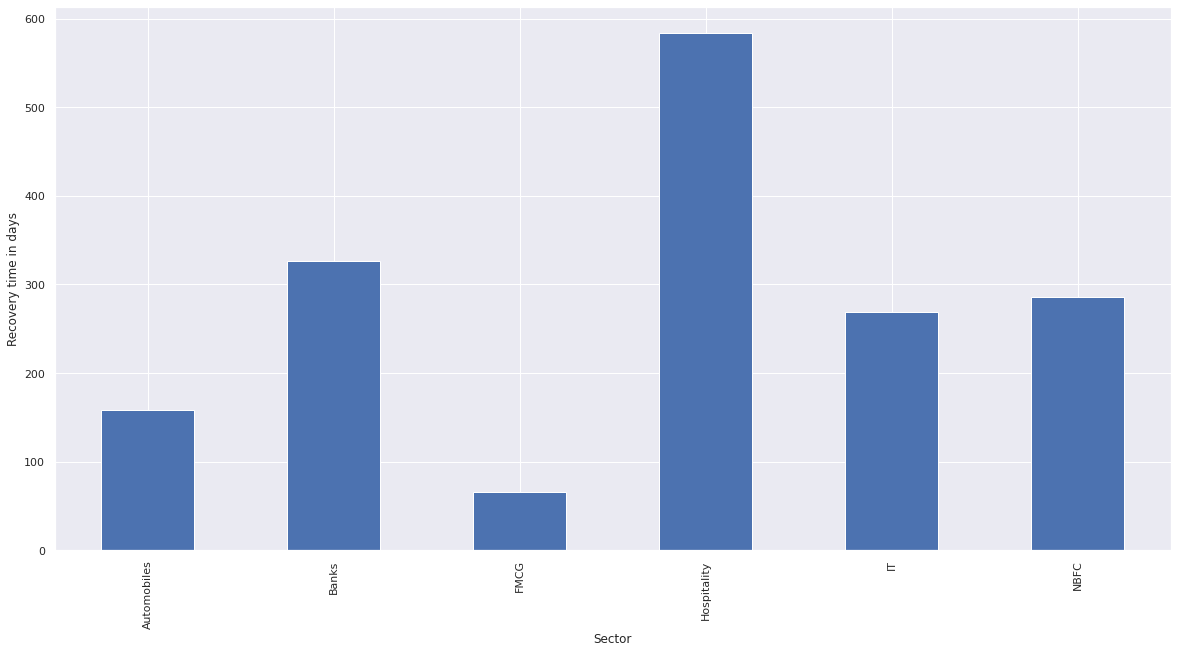

In [30]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.xlabel("Sector")
plt.ylabel("Recovery time in days")

cdfg['Recovery Time  tr'].plot.bar()

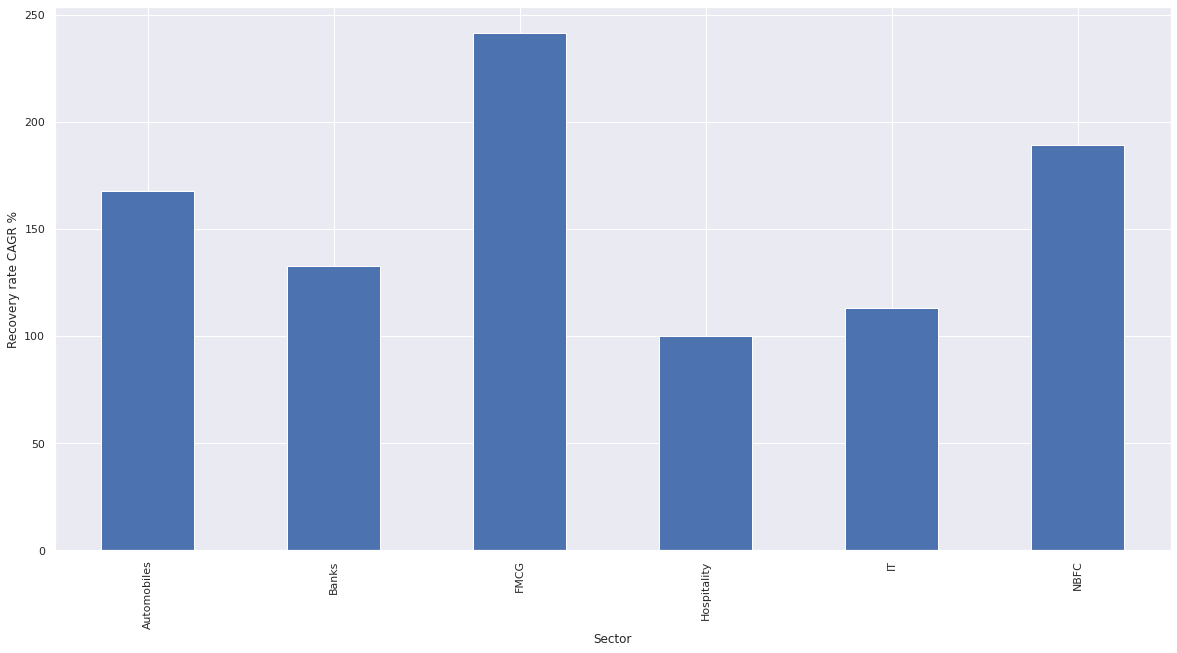

In [29]:

cdfg['Recovery CAGR'] = cdfg['Post-Covid Recovery Rate  rr']/(cdfg['Recovery Time  tr']/365)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.xlabel("Sector")
plt.ylabel("Recovery rate CAGR %")

cdfg['Recovery CAGR'].plot.bar()

In [32]:
cdfg

,downfall,Pre-Covid Peak,Post-Covid Low,Pre-Covid CAGR,Post-Covid Recovery Rate rr,Recovery Time tr,Recovery CAGR
Sector,,,,,,,
Automobiles,32.573821,1682.733750,1205.588750,-6.136773,72.629748,158.00,167.783911
Banks,45.018441,513.550000,309.762500,14.081124,118.877235,326.75,132.793239
FMCG,26.020016,1830.366667,1400.883333,31.515859,43.679339,66.00,241.559983
Hospitality,56.068891,133.425000,58.650000,-0.528500,159.975000,584.00,99.984375
IT,24.246189,871.912500,682.737500,14.944579,83.554457,269.50,113.162809
NBFC,54.101281,2259.812500,996.337500,40.369272,148.472535,286.25,189.318692
